# Triplet Network Evaluation


In [1]:
# Move to the directory where the notebook is located
# and set directory to Deep_Learning-Based_Signature_Forgery_Detection_for_Personal_Identity_Authentication
%cd ..

c:\Users\USER\Downloads\chương trình học UEH\môn học kì 4\PPNC\Project\Deep_Learning-Based_Signature_Forgery_Detection_for_Personal_Identity_Authentication


C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
# Đảm bảo đang ở Deep_Learning-Based_Signature_Forgery_Detection_for_Personal_Identity_Authentication
# Cài đặt package
!pip install -e .

Obtaining file:///C:/Users/USER/Downloads/ch%C6%B0%C6%A1ng%20tr%C3%ACnh%20h%E1%BB%8Dc%20UEH/m%C3%B4n%20h%E1%BB%8Dc%20k%C3%AC%204/PPNC/Project/Deep_Learning-Based_Signature_Forgery_Detection_for_Personal_Identity_Authentication
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Building editable for signature_verification (pyproject.toml): started
  Building editable for signature_verification (pyproject.toml): finished with status 'done'
  Created wheel for signature_verification: filename=signature_verification-0.1.0-0.editable-py3-none-any.whl s

In [3]:
import os
import sys
import time
import gc
import random
import psutil
import shutil
import kagglehub
import itertools

import torch
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import defaultdict

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, confusion_matrix, precision_recall_curve
)

from utils.helpers import load_config, get_model_from_Kaggle, load_model
from models.feature_extractor import ResNetFeatureExtractor
from models.triplet_network import TripletNetwork

In [4]:
print(os.getcwd())

c:\Users\USER\Downloads\chương trình học UEH\môn học kì 4\PPNC\Project\Deep_Learning-Based_Signature_Forgery_Detection_for_Personal_Identity_Authentication


## 1. Dataset Processing

In [5]:
pathA = kagglehub.dataset_download("divyanshrai/handwritten-signatures")
print("Path to dataset files [divyanshrai]:", pathA) #dataset A

Path to dataset files [divyanshrai]: C:\Users\USER\.cache\kagglehub\datasets\divyanshrai\handwritten-signatures\versions\2


In [6]:
dataset = r'C:\Users\USER\.cache\kagglehub\datasets\divyanshrai\handwritten-signatures\versions\2\sample_Signature\sample_Signature'
sys.path.append(dataset)

In [7]:
def rename_files(dataset_path):
    # Tạo các thư mục genuines và forged nếu chưa có
    genuines_dir = os.path.join(dataset_path, 'genuines_rename')
    forged_dir = os.path.join(dataset_path, 'forged_rename')
    os.makedirs(genuines_dir, exist_ok=True)
    os.makedirs(forged_dir, exist_ok=True)

    # Duyệt qua tất cả các file trong dataset
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.startswith('NFI-') and (file.endswith('.png') or file.endswith('.PNG')):
                # Trích xuất XXX, YY, ZZZ từ tên file
                parts = file.split('-')[1].split('.')[0]
                XXX = parts[:3]  # ID người thực hiện chữ ký
                YY = parts[3:5]  # Số thứ tự mẫu ảnh
                ZZZ = parts[5:]  # ID người sở hữu chữ ký

                # Xác định là genuine hay forged và đặt tên mới
                if XXX == ZZZ:
                    new_name = f'original_{ZZZ}_{YY}.png'
                    target_dir = genuines_dir
                else:
                    new_name = f'forgery_{ZZZ}_{YY}.png'
                    target_dir = forged_dir

                # Đường dẫn file cũ và mới
                old_path = os.path.join(root, file)
                new_path = os.path.join(target_dir, new_name)

                # Di chuyển và đổi tên file
                shutil.move(old_path, new_path)
                print(f'Đã đổi tên: {file} -> {new_name}')

dataset_path = dataset
rename_files(dataset_path)

In [8]:
genuines_dir = dataset + '/genuines_rename'
forgery_dir = dataset + '/forged_rename'

# Preprocess data: Organize signatures by writer ID
writers = defaultdict(lambda: {'genuines': [], 'forged': []})

# Parse genuine signatures
for fname in os.listdir(genuines_dir):
    if fname.lower().endswith(('.png')):
        parts = fname.split('_')
        if len(parts) == 3 and parts[0] == 'original':
            writer_id = parts[1]  # e.g., '001' from 'original_001_01.png'
            writers[writer_id]['genuines'].append(os.path.join(genuines_dir, fname))

# Parse forged signatures
for fname in os.listdir(forgery_dir):
    if fname.lower().endswith(('.png')):
        parts = fname.split('_')
        if len(parts) == 3 and parts[0] == 'forgery':
            # e.g., '001' from 'forgery_001_01.png'
            writer_id = parts[1]  
            writers[writer_id]['forged'].append(os.path.join(forgery_dir, fname))

print(f"Number of writers: {len(writers)}")
# Print sample
for writer_id, data in list(writers.items())[:32]:  
    print(f"Writer {writer_id}: {len(data['genuines'])} genuines, {len(data['forged'])} forged")

# Tạo cặp chữ ký từ toàn bộ dataset
pairs, labels = [], []

for writer_id, imgs in writers.items():
    genuines = imgs['genuines']
    forged = imgs['forged']
    
    # Chỉ tạo cặp nếu writer có ít nhất 2 chữ ký thật và 1 chữ ký giả
    if len(genuines) >= 2 and forged:
        n = len(genuines)  # Số chữ ký thật
        m = len(forged)    # Số chữ ký giả
        
        # Tính số lượng cặp có thể tạo
        num_gen_gen = n * (n - 1) // 2  # C(n, 2)
        num_gen_forged = n * m          # n * m
        
        # Lấy số cặp tối đa để cân bằng
        p = min(num_gen_gen, num_gen_forged)
        
        # Tạo cặp genuine-genuine
        if p == num_gen_gen:
            gen_gen_pairs = list(itertools.combinations(genuines, 2))
        else:
            all_gen_gen = list(itertools.combinations(genuines, 2))
            gen_gen_pairs = random.sample(all_gen_gen, p)
        
        for pair in gen_gen_pairs:
            pairs.append(pair)
            labels.append(1)
        
        # Tạo cặp genuine-forged
        if p == num_gen_forged:
            gen_forged_pairs = list(itertools.product(genuines, forged))
        else:
            all_gen_forged = list(itertools.product(genuines, forged))
            gen_forged_pairs = random.sample(all_gen_forged, p)
        
        for pair in gen_forged_pairs:
            pairs.append(pair)
            labels.append(0)

# In kết quả
print(f"Đã tạo {len(pairs)} cặp: {sum(labels)} genuine-genuine, {len(labels) - sum(labels)} genuine-forged")

Number of writers: 30
Writer 001: 5 genuines, 5 forged
Writer 002: 5 genuines, 5 forged
Writer 003: 5 genuines, 5 forged
Writer 004: 5 genuines, 5 forged
Writer 005: 5 genuines, 5 forged
Writer 006: 5 genuines, 5 forged
Writer 007: 5 genuines, 5 forged
Writer 008: 5 genuines, 5 forged
Writer 009: 5 genuines, 5 forged
Writer 010: 5 genuines, 4 forged
Writer 011: 5 genuines, 5 forged
Writer 012: 5 genuines, 5 forged
Writer 013: 5 genuines, 5 forged
Writer 014: 5 genuines, 5 forged
Writer 015: 5 genuines, 5 forged
Writer 016: 5 genuines, 5 forged
Writer 017: 5 genuines, 5 forged
Writer 018: 5 genuines, 5 forged
Writer 019: 5 genuines, 5 forged
Writer 020: 5 genuines, 5 forged
Writer 021: 5 genuines, 5 forged
Writer 022: 5 genuines, 5 forged
Writer 023: 5 genuines, 5 forged
Writer 024: 5 genuines, 5 forged
Writer 025: 5 genuines, 5 forged
Writer 026: 5 genuines, 5 forged
Writer 027: 5 genuines, 5 forged
Writer 028: 5 genuines, 5 forged
Writer 029: 5 genuines, 5 forged
Writer 030: 5 genuine

## 2. Resource Measurement & Model Loader

- `MemoryTracker`: theo dõi start, peak, end memory  
- Load config, model, transform


In [9]:
# Memory tracking class
class MemoryTracker:
    def __init__(self):
        self.proc = psutil.Process(os.getpid())
        self.start = self.peak = self.end = None

    def start_tracking(self):
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        self.start = self.proc.memory_info().rss / 1e6
        self.peak = self.start

    def update(self):
        cur = self.proc.memory_info().rss / 1e6
        self.peak = max(self.peak, cur)

    def end_tracking(self):
        self.end = self.proc.memory_info().rss / 1e6

    def summary(self):
        return {
            'start_MB': self.start,
            'peak_MB': self.peak,
            'end_MB': self.end,
            'delta_MB': self.end - self.start
        }

# Load configuration
config = load_config('configs/config_triplet.yaml')

# Device
device = torch.device('cuda' if torch.cuda.is_available() and config['device']=='cuda' else 'cpu')
print(f"Using device: {device}")

# Load model
print("Loading model...")
model_path = get_model_from_Kaggle(config['model']['kaggle_handle'])
model = load_model(
    model_path,
    config['model']['backbone'],
    config['model']['feature_dim'],
    config['model']['name']
)
model.to(device).eval()

# Image transform
size = config['dataset']['input_size']
if isinstance(size, str):
    size = tuple(map(int, size.strip('()').split(',')))
transform = transforms.Compose([
    transforms.Resize((220, 150)),
    transforms.Grayscale(),  # Đảm bảo ảnh 1 kênh xám
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # 1 kênh -> 3 kênh
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

Using device: cuda
Loading model...
Model downloaded to C:\Users\USER\.cache\kagglehub\models\giahuytranviet\triplet-verification-model\pyTorch\default\2


c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model loaded successfully
Model loaded from C:\Users\USER\.cache\kagglehub\models\giahuytranviet\triplet-verification-model\pyTorch\default\2


## 3. Similarity Extraction

In [10]:
# Tính similarity
tracker = MemoryTracker()
tracker.start_tracking()
t0 = time.time()

sims = []
for idx, (p, q) in enumerate(tqdm(pairs, desc="Computing similarities")):
    img1 = transform(Image.open(p).convert('RGB')).unsqueeze(0).to(device)
    img2 = transform(Image.open(q).convert('RGB')).unsqueeze(0).to(device)
    with torch.no_grad():
        f1 = model.feature_extractor(img1)
        f2 = model.feature_extractor(img2)
    dist = F.pairwise_distance(f1, f2).item()
    sims.append(1.0 / (1.0 + dist))
    if idx % 50 == 0:
        tracker.update()

tracker.end_tracking()
exec_time = time.time() - t0
mem_stats = tracker.summary()
print(f"Execution time: {exec_time:.2f}s")
print("Memory usage (MB):", mem_stats)


Computing similarities: 100%|██████████| 600/600 [00:24<00:00, 24.85it/s]

Execution time: 24.15s
Memory usage (MB): {'start_MB': 3397.750784, 'peak_MB': 5285.00736, 'end_MB': 4967.084032, 'delta_MB': 1569.333248}


## 4. Comprehensive Metrics & Confusion Matrix

- Tính Accuracy, Precision, Recall, F1, ROC-AUC  
- Confusion matrix với threshold mặc định 0.5


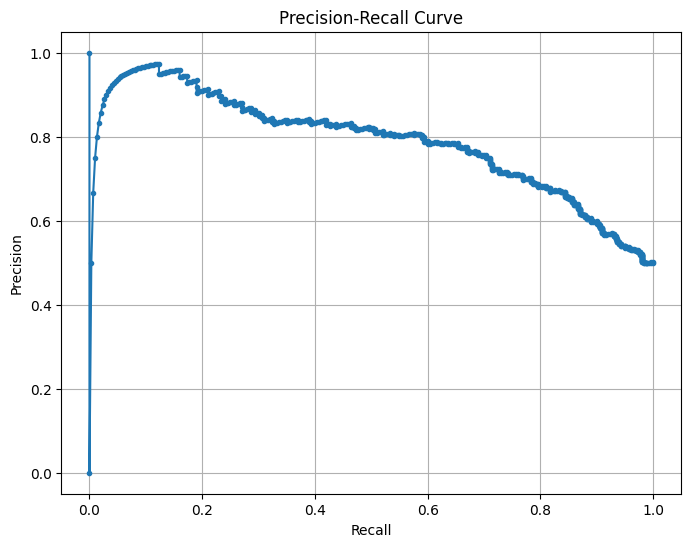

Ngưỡng tối ưu: 0.1166 với Accuracy: 0.7383


In [11]:
# Tính Precision, Recall cho các ngưỡng
precision, recall, thresholds = precision_recall_curve(labels, sims)

# Vẽ đồ thị Precision-Recall
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

# Tính Accuracy cho từng ngưỡng
accuracies = []
for threshold in thresholds:
    # Dự đoán nhãn dựa trên ngưỡng
    predictions = (sims >= threshold).astype(int)
    # Tính Accuracy
    accuracy = accuracy_score(labels, predictions)
    accuracies.append(accuracy)

# Tìm ngưỡng tối ưu dựa trên Accuracy
optimal_idx = np.argmax(accuracies)
optimal_threshold = thresholds[optimal_idx]
print(f"Ngưỡng tối ưu: {optimal_threshold:.4f} với Accuracy: {accuracies[optimal_idx]:.4f}")

In [16]:
threshold = 0.1166
preds = (np.array(sims) > threshold).astype(int)

# Metrics
acc   = accuracy_score(labels, preds)
pre   = precision_score(labels, preds)
rec   = recall_score(labels, preds)
f1    = f1_score(labels, preds)
fpr, tpr, _ = roc_curve(labels, sims)
roc_auc = auc(fpr, tpr)
cm    = confusion_matrix(labels, preds)

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {pre:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"ROC AUC  : {roc_auc:.4f}")
print("Confusion Matrix:\n", cm)

Accuracy : 0.7383
Precision: 0.7563
Recall   : 0.7033
F1-score : 0.7288
ROC AUC  : 0.7883
Confusion Matrix:
 [[232  68]
 [ 89 211]]


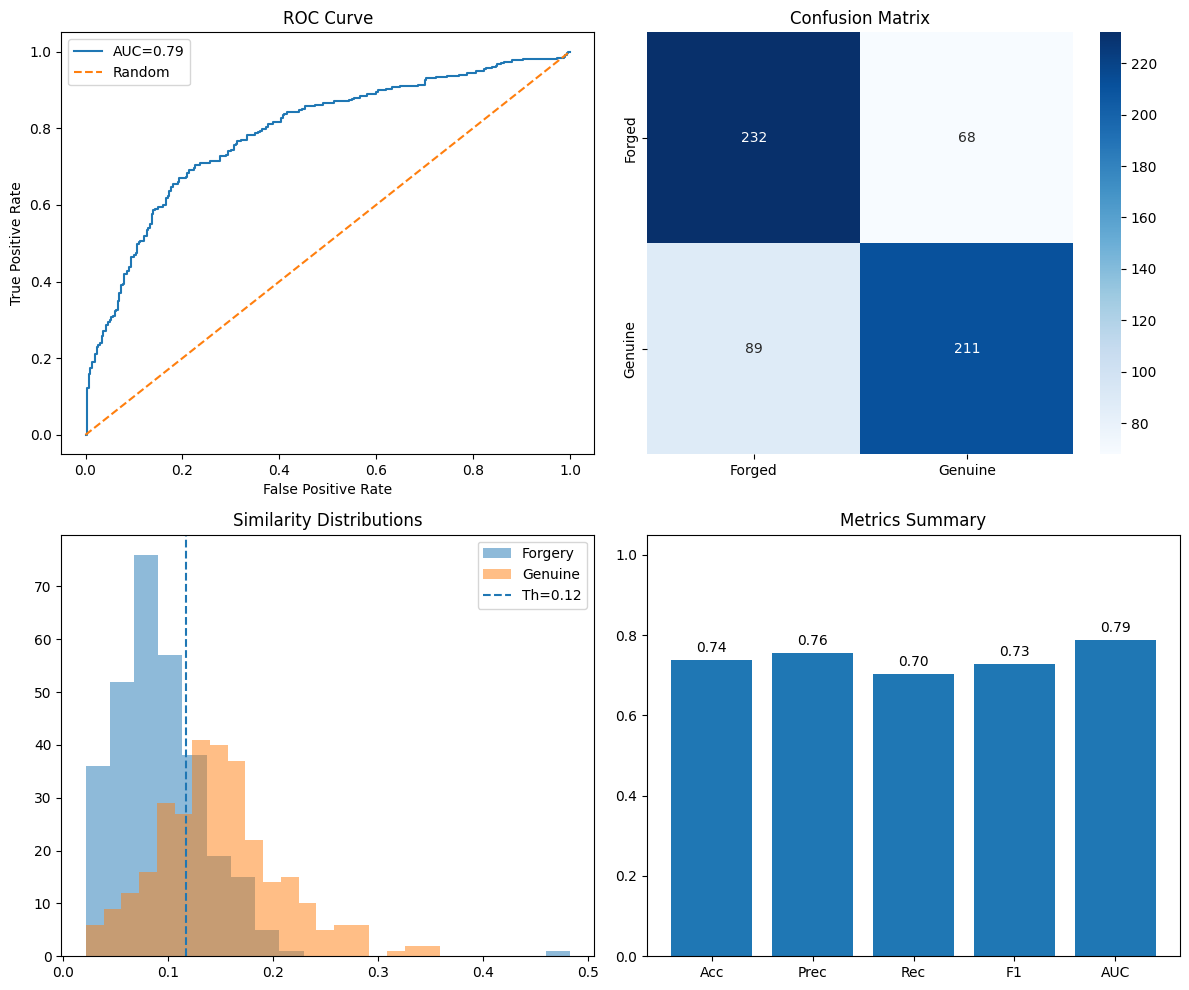

In [17]:
plt.figure(figsize=(12,10))

# ROC Curve
plt.subplot(2,2,1)
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.2f}")
plt.plot([0,1],[0,1],'--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Confusion Matrix heatmap
plt.subplot(2,2,2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Forged','Genuine'],
            yticklabels=['Forged','Genuine'])
plt.title('Confusion Matrix')

# Similarity distributions
plt.subplot(2,2,3)
g_sim = np.array(sims)[np.array(labels)==1]
f_sim = np.array(sims)[np.array(labels)==0]
plt.hist(f_sim, bins=20, alpha=0.5, label='Forgery')
plt.hist(g_sim, bins=20, alpha=0.5, label='Genuine')
plt.axvline(threshold, linestyle='--', label=f'Th={threshold:.2f}')
plt.title('Similarity Distributions')
plt.legend()

# Metrics bar chart
plt.subplot(2,2,4)
metrics = ['Acc','Prec','Rec','F1','AUC']
values  = [acc, pre, rec, f1, roc_auc]
plt.bar(metrics, values)
plt.ylim(0,1.05)
for i,v in enumerate(values):
    plt.text(i, v+0.02, f"{v:.2f}", ha='center')
plt.title('Metrics Summary')

plt.tight_layout()
plt.show()

## 5. Test

In [18]:
def test_signature(anchor_path, test_path, model, transform, threshold=0.1166, device='cpu'):
    model.to(device)
    model.eval()

    img_anchor = Image.open(anchor_path).convert('RGB')
    img_test = Image.open(test_path).convert('RGB')

    img_anchor = transform(img_anchor).unsqueeze(0).to(device)
    img_test = transform(img_test).unsqueeze(0).to(device)

    with torch.no_grad():
        emb_anchor = model.feature_extractor(img_anchor)
        emb_test = model.feature_extractor(img_test)

    dist = F.pairwise_distance(emb_anchor, emb_test).item()
    similarity = 1.0 / (1.0 + dist)

    # Hiển thị hình ảnh bằng matplotlib
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(Image.open(anchor_path).convert('RGB'))
    axes[0].set_title('Anchor (Genuine)')
    axes[0].axis('off')
    axes[1].imshow(Image.open(test_path).convert('RGB'))
    axes[1].set_title('Test')
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()  # Hiển thị hình ảnh

    print(f"Similarity: {similarity:.4f}")
    conclusion = "THẬT" if similarity > threshold else "GIẢ"
    print(f"Kết luận: Ảnh chữ ký ĐƯỢC cho là {conclusion}.")


Testing with writer 001, true label: 0


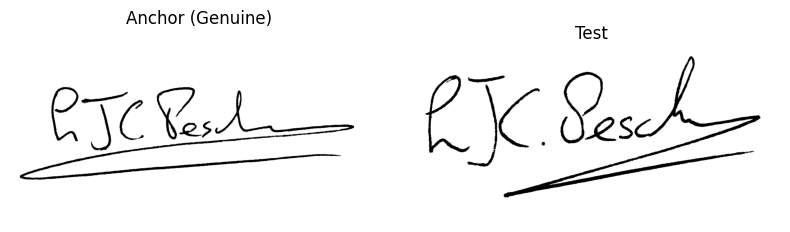

Similarity: 0.0402
Kết luận: Ảnh chữ ký ĐƯỢC cho là GIẢ.


In [29]:
# Test with person number 1
writer_id = '001'

anchor_path = random.choice(writers[writer_id]['genuines'])
all_signatures = writers[writer_id]['genuines'] + writers[writer_id]['forged']
test_path = random.choice(all_signatures)
while test_path == anchor_path and len(all_signatures) > 1:
    test_path = random.choice(all_signatures)
true_label = 1 if test_path in writers[writer_id]['genuines'] else 0

print(f"\nTesting with writer {writer_id}, true label: {true_label}")
test_signature(anchor_path, test_path, model, transform, threshold=0.1166, device=device)